In [1]:
import argparse
import os, sys
import time
import datetime

# Import pytorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm

# You cannot change this line.
from tools.dataloader import CIFAR10

# Import other packages
import matplotlib.pyplot as plt

In [2]:
""" 
Assignment 2(a)
Build the LeNet-5 model by following table 1 or figure 1.

You can also insert batch normalization and leave the LeNet-5 
with batch normalization here for assignment 3(c).
"""
# Create the neural network module: LeNet-5
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()  
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0, bias=True)
        #self.maxPool1 = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        self.conv2 =nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        #self.maxPool2 = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        self.fc1 =  nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
                               
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, kernel_size = 2, stride = 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, kernel_size = 2, stride = 2)
        out = out.view(out.size(0),-1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        
        return out

In [3]:
"""
Hyperparameter optimization in assignment 4(a), 4(b) can be 
conducted here.
Be sure to leave only your best hyperparameter combination
here and comment the original hyperparameter settings.
"""

# Setting some hyperparameters
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100
INITIAL_LR = 0.01
MOMENTUM = 0.9
REG = 1e-4
EPOCHS = 30
DATAROOT = "./data"
CHECKPOINT_PATH = "./saved_models"

**Your answer:**

In [4]:
"""
Assignment 2(b)
Write functions to load dataset and preprocess the incoming data. 
We recommend that the preprocess scheme \textbf{must} include 
normalize, standardization, batch shuffling to make sure the training 
process goes smoothly. 
The preprocess scheme may also contain some data augmentation methods 
(e.g., random crop, random flip, etc.). 

Reference value for mean/std:

mean(RGB-format): (0.4914, 0.4822, 0.4465)
std(RGB-format): (0.2023, 0.1994, 0.2010)


NOTE: Considering this process has strong corrlelation with assignment 3(b), 
please leave the data preprocessing method which can achieve the highest 
validation accuracy here. You can include your original data augmentation
method as comments and denotes the accuracy difference between thest two 
methods.
"""
# Specify preprocessing function.
# Reference mean/std value for 
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])])

**Your answer:**

In [5]:
# Call the dataset Loader
trainset = CIFAR10(root=DATAROOT, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=1)
valset = CIFAR10(root=DATAROOT, train=False, download=True, transform=transform_val)
valloader = torch.utils.data.DataLoader(valset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=1)

Using downloaded and verified file: ./data/cifar10_trainval.tar.gz
Extracting ./data/cifar10_trainval.tar.gz to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval.tar.gz
Extracting ./data/cifar10_trainval.tar.gz to ./data
Files already downloaded and verified


In [6]:
#### Specify the device for computation
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = LeNet5()
net = net.to(device)
if device =='cuda':
    print("Train on GPU...")
else:
    print("Train on CPU...")

Train on GPU...


In [7]:
# FLAG for loading the pretrained model
TRAIN_FROM_SCRATCH = False
# Code for loading checkpoint and recover epoch id.
CKPT_PATH = "./saved_models/model.h5"
def get_checkpoint(ckpt_path):
    try:
        ckpt = torch.load(ckpt_path)
    except Exception as e:
        print(e)
        return None
    return ckpt

ckpt = get_checkpoint(CKPT_PATH)
if ckpt is None or TRAIN_FROM_SCRATCH:
    if not TRAIN_FROM_SCRATCH:
        print("Checkpoint not found.")
    print("Training from scratch ...")
    start_epoch = 0
    current_learning_rate = INITIAL_LR
else:
    print("Successfully loaded checkpoint: %s" %CKPT_PATH)
    net.load_state_dict(ckpt['net'])
    start_epoch = ckpt['epoch'] + 1
    current_learning_rate = ckpt['lr']
    print("Starting from epoch %d " %start_epoch)

print("Starting from learning rate %f:" %current_learning_rate)

Successfully loaded checkpoint: ./saved_models/model.h5
Starting from epoch 26 
Starting from learning rate 0.010000:


In [7]:
"""
Assignment 2(c)
In the targeted classification task, we use cross entropy loss with L2 
regularization as the learning object.
You need to formulate the cross-entropy loss function in PyTorch.
You should also specify a PyTorch Optimizer to optimize this loss function.
We recommend you to use the SGD-momentum with an initial learning rate 0.01 
and momentum 0.9 as a start.
"""
# Create loss function and specify regularization
criterion = nn.CrossEntropyLoss()
# Add optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=REG)

In [9]:
"""
Assignment 3(a)
Start the training process over the whole CIFAR-10 training dataset. 
For sanity check, you are required to report the initial loss value at 
the beginning of the training process and briefly justify this value. 
Run the training process for \textbf{a maximum of 30} epochs and you 
should be able to reach around \textbf{65\%} accuracy on the validation 
dataset.
"""
# Report the initial loss value
init_loss = 0
net.eval()
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(valloader):
        # Copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Zero the gradient
        optimizer.zero_grad()
        # Generate output from the DNN.
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        init_loss += loss

    avg_loss = init_loss / len(valloader)
    print("The initial loss value: %.4f" %(avg_loss))


# Start the training/validation process
# The process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
global_step = 0
best_val_acc = 0

for i in range(start_epoch, EPOCHS):
    print(datetime.datetime.now())
    # Switch to train mode
    net.train()
    print("Epoch %d:" %i)

    total_examples = 0
    correct_examples = 0

    train_loss = 0
    train_acc = 0
    # Train the training dataset for 1 epoch.
    print(len(trainloader))
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # Copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Zero the gradient
        optimizer.zero_grad()
        # Generate output
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        # Now backward loss
        loss.backward()
        # Apply gradient
        optimizer.step()
        # Calculate predicted labels
        _, predicted = torch.max(outputs.data, 1)
        # Calculate accuracy
        total_examples += targets.size(0)
        correct_examples += torch.sum(predicted == targets.data).float()

        train_loss += loss

        global_step += 1
        if global_step % 100 == 0:
            avg_loss = train_loss / (batch_idx + 1)
        pass
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
    print(datetime.datetime.now())
    # Validate on the validation dataset
    print("Validation...")
    total_examples = 0
    correct_examples = 0
    
    net.eval()

    val_loss = 0
    val_acc = 0
    # Disable gradient during validation
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            # Copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Zero the gradient
            optimizer.zero_grad()
            # Generate output from the DNN.
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            # Calculate predicted labels
            _, predicted = outputs.max(1)
            # Calculate accuracy
            total_examples += targets.size(0)
            correct_examples += torch.sum(predicted == targets.data).float()
            val_loss += loss

    avg_loss = val_loss / len(valloader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

        
    """
    Assignment 4(b)
    Learning rate is an important hyperparameter to tune. Specify a 
    learning rate decay policy and apply it in your training process. 
    Briefly describe its impact on the learning curveduring your 
    training process.    
    Reference learning rate schedule: 
    decay 0.98 for every 2 epochs. You may tune this parameter but 
    minimal gain will be achieved.
    Assignment 4(c)
    As we can see from above, hyperparameter optimization is critical 
    to obtain a good performance of DNN models. Try to fine-tune the 
    model to over 70% accuracy. You may also increase the number of 
    epochs to up to 100 during the process. Briefly describe what you 
    have tried to improve the performance of the LeNet-5 model.
    """
    DECAY_EPOCHS = 2
    DECAY = 1.00
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate*DECAY
        for param_group in optimizer.param_groups:
            # Assign the learning rate parameter
            param_group['lr'] = current_learning_rate
            
        print("Current learning rate has decayed to %f" %current_learning_rate)
    
    # Save for checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_PATH):
            os.makedirs(CHECKPOINT_PATH)
        print("Saving ...")
        state = {'net': net.state_dict(),
                 'epoch': i,
                 'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_PATH, 'model.h5'))

print("Optimization finished.")

The initial loss value: 2.3029
2019-10-09 05:13:35.851945
Epoch 0:
352
Training loss: 2.2002, Training accuracy: 0.2143
2019-10-09 05:13:49.054940
Validation...
Validation loss: 1.8636, Validation accuracy: 0.3482
Saving ...
2019-10-09 05:13:50.119898
Epoch 1:
352
Training loss: 1.7641, Training accuracy: 0.3662
2019-10-09 05:14:02.089020
Validation...
Validation loss: 1.5278, Validation accuracy: 0.4384
Saving ...
2019-10-09 05:14:03.454946
Epoch 2:
352
Training loss: 1.5268, Training accuracy: 0.4420
2019-10-09 05:14:14.946942
Validation...
Validation loss: 1.4512, Validation accuracy: 0.4680
Current learning rate has decayed to 0.010000
Saving ...
2019-10-09 05:14:16.040688
Epoch 3:
352
Training loss: 1.4225, Training accuracy: 0.4857
2019-10-09 05:14:27.872918
Validation...
Validation loss: 1.3286, Validation accuracy: 0.5312
Saving ...
2019-10-09 05:14:28.950472
Epoch 4:
352
Training loss: 1.3437, Training accuracy: 0.5183
2019-10-09 05:14:40.870345
Validation...
Validation loss: 

In [7]:
class model_param_eval():
    def __init__(self,model_name, net=net, EPOCHS = 30):
        self.model_name = model_name
        self.net = net
        self.EPOCHS = EPOCHS
    
    def train_eval(self, trainloader=trainloader, valloader=valloader, REG=REG, INITIAL_LR=INITIAL_LR, MOMENTUM=MOMENTUM, plot=False):
        TRAIN_FROM_SCRATCH = False
        # Code for loading checkpoint and recover epoch id.
        CKPT_PATH = "./saved_models/" + self.model_name
        def get_checkpoint(ckpt_path):
            try:
                ckpt = torch.load(ckpt_path)
            except Exception as e:
                print(e)
                return None
            return ckpt

        ckpt = get_checkpoint(CKPT_PATH)
        if ckpt is None or TRAIN_FROM_SCRATCH:
            if not TRAIN_FROM_SCRATCH:
                print("Checkpoint not found.")
            print("Training from scratch ...")
            start_epoch = 0
            current_learning_rate = INITIAL_LR
        else:
            print("Successfully loaded checkpoint: %s" %CKPT_PATH)
            self.net.load_state_dict(ckpt['net'])
            start_epoch = ckpt['epoch'] + 1
            current_learning_rate = ckpt['lr']
            print("Starting from epoch %d " %start_epoch)

        print("Starting from learning rate %f:" %current_learning_rate)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)

        global_step = 0
        best_val_acc = 0
        
        trainloss_list = list()
        valloss_list = list()
        trainacc_list = list()
        valacc_list = list()
        
        for i in range(start_epoch, self.EPOCHS):
            print(datetime.datetime.now())
            self.net.train()
            print("Epoch %d:" %i)

            total_examples = 0
            correct_examples = 0

            train_loss = 0
            train_acc = 0
            print(len(trainloader))
            for batch_idx, (inputs, targets) in enumerate(trainloader):
                inputs = inputs.to(device)
                targets = targets.to(device)
                optimizer.zero_grad()
                outputs = self.net(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs.data, 1)
                total_examples += targets.size(0)
                correct_examples += torch.sum(predicted == targets.data).float()

                train_loss += loss

                global_step += 1
                if global_step % 100 == 0:
                    avg_loss = train_loss / (batch_idx + 1)
                pass
            avg_acc = correct_examples / total_examples
            print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
            print(datetime.datetime.now())
            trainacc_list.append(avg_acc)
            trainloss_list.append(avg_loss)
        
            # Validate on the validation dataset
            print("Validation...")
            total_examples = 0
            correct_examples = 0

            self.net.eval()

            val_loss = 0
            val_acc = 0
            # Disable gradient during validation
            with torch.no_grad():
                for batch_idx, (inputs, targets) in enumerate(valloader):
                    # Copy inputs to device
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    # Zero the gradient
                    optimizer.zero_grad()
                    # Generate output from the DNN.
                    outputs = self.net(inputs)
                    loss = criterion(outputs, targets)
                    # Calculate predicted labels
                    _, predicted = outputs.max(1)
                    # Calculate accuracy
                    total_examples += targets.size(0)
                    correct_examples += torch.sum(predicted == targets.data).float()
                    val_loss += loss

            avg_loss = val_loss / len(valloader)
            avg_acc = correct_examples / total_examples
            print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

            valacc_list.append(avg_acc)
            valloss_list.append(avg_loss)

            current_learning_rate = INITIAL_LR

            DECAY_EPOCHS = 2
            DECAY = 1.00
            if i % DECAY_EPOCHS == 0 and i != 0:
                current_learning_rate = current_learning_rate*DECAY
                for param_group in optimizer.param_groups:
                    # Assign the learning rate parameter
                    param_group['lr'] = current_learning_rate

                print("Current learning rate has decayed to %f" %current_learning_rate)

            # Save for checkpoint
            if avg_acc > best_val_acc:
                best_val_acc = avg_acc
                if not os.path.exists(CHECKPOINT_PATH):
                    os.makedirs(CHECKPOINT_PATH)
                print("Saving ...")
                state = {'net': self.net.state_dict(),
                         'epoch': i,
                         'lr': current_learning_rate}
                torch.save(state, os.path.join(CHECKPOINT_PATH, self.model_name))
        print("Optimization finished.")
        
        if plot == True:
            plt.figure(figsize=(6,8))
            plt.subplot(211)
            plt.title('Loss Curve')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.plot(valloss_list, label='validation loss', color='red', linestyle = ':')
            plt.plot(trainloss_list, label='training loss', color='green', linestyle='-')
            plt.legend()

            plt.subplot(212)
            plt.title('Accuracy')
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            plt.plot(valacc_list, label='validation accuracy', color='red', linestyle=':')
            plt.plot(trainacc_list, label='training accuracy', color='green', linestyle='-')
            plt.legend()
            plt.show()
    

In [8]:
#3(b)
#################################################################################################################
transform_train0 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])])

transform_val0 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])])

trainset0 = CIFAR10(root=DATAROOT, train=True, download=True, transform=transform_train0)
trainloader0 = torch.utils.data.DataLoader(trainset0, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=1)
valset0 = CIFAR10(root=DATAROOT, train=False, download=True, transform=transform_val0)
valloader0 = torch.utils.data.DataLoader(valset0, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=1)

#################################################################################################################
transform_train1 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])])

transform_val1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])])

trainset1 = CIFAR10(root=DATAROOT, train=True, download=True, transform=transform_train1)
trainloader1 = torch.utils.data.DataLoader(trainset1, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=1)
valset1 = CIFAR10(root=DATAROOT, train=False, download=True, transform=transform_val1)
valloader1 = torch.utils.data.DataLoader(valset1, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=1)

Using downloaded and verified file: ./data/cifar10_trainval.tar.gz
Extracting ./data/cifar10_trainval.tar.gz to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval.tar.gz
Extracting ./data/cifar10_trainval.tar.gz to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval.tar.gz
Extracting ./data/cifar10_trainval.tar.gz to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval.tar.gz
Extracting ./data/cifar10_trainval.tar.gz to ./data
Files already downloaded and verified


[Errno 2] No such file or directory: './saved_models/model0.h5'
Checkpoint not found.
Training from scratch ...
Starting from learning rate 0.010000:
2019-10-09 15:30:56.652877
Epoch 0:
352
Training loss: 2.1020, Training accuracy: 0.2649
2019-10-09 15:31:10.765563
Validation...
Validation loss: 1.8135, Validation accuracy: 0.3746
Saving ...
2019-10-09 15:31:11.897855
Epoch 1:
352
Training loss: 1.6811, Training accuracy: 0.4214
2019-10-09 15:31:21.150942
Validation...
Validation loss: 1.5689, Validation accuracy: 0.4654
Saving ...
2019-10-09 15:31:22.528995
Epoch 2:
352
Training loss: 1.5042, Training accuracy: 0.4916
2019-10-09 15:31:31.804476
Validation...
Validation loss: 1.4542, Validation accuracy: 0.5094
Current learning rate has decayed to 0.010000
Saving ...
2019-10-09 15:31:32.924971
Epoch 3:
352
Training loss: 1.3736, Training accuracy: 0.5370
2019-10-09 15:31:41.951218
Validation...
Validation loss: 1.2548, Validation accuracy: 0.5620
Saving ...
2019-10-09 15:31:43.056973
E

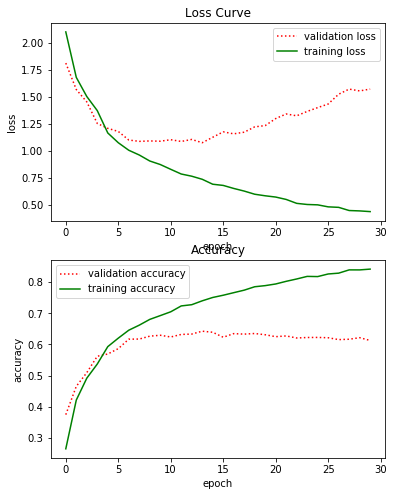

[Errno 2] No such file or directory: './saved_models/model1.h5'
Checkpoint not found.
Training from scratch ...
Starting from learning rate 0.010000:
2019-10-09 15:36:08.332428
Epoch 0:
352
Training loss: 1.3427, Training accuracy: 0.5497
2019-10-09 15:36:20.088645
Validation...
Validation loss: 1.1347, Validation accuracy: 0.6152
Saving ...
2019-10-09 15:36:21.196732
Epoch 1:
352
Training loss: 1.1779, Training accuracy: 0.5917
2019-10-09 15:36:32.637005
Validation...
Validation loss: 1.0915, Validation accuracy: 0.6200
Saving ...
2019-10-09 15:36:33.764998
Epoch 2:
352
Training loss: 1.1453, Training accuracy: 0.6014
2019-10-09 15:36:45.021142
Validation...
Validation loss: 1.0320, Validation accuracy: 0.6384
Current learning rate has decayed to 0.010000
Saving ...
2019-10-09 15:36:46.317710
Epoch 3:
352
Training loss: 1.1136, Training accuracy: 0.6113
2019-10-09 15:36:57.643033
Validation...
Validation loss: 1.0326, Validation accuracy: 0.6468
Saving ...
2019-10-09 15:36:58.720986
E

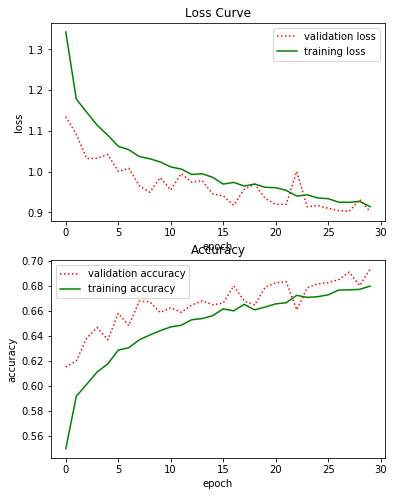

In [10]:
#################################################################################################################
eval_model0 = model_param_eval(model_name='model0.h5', net=net)
eval_model0.train_eval(INITIAL_LR=0.01, trainloader= trainloader0, valloader=valloader0,plot=True)

#################################################################################################################
eval_model1 = model_param_eval(model_name='model1.h5', net=net)
eval_model1.train_eval(INITIAL_LR=0.01, trainloader= trainloader1, valloader=valloader1,plot=True)

[Errno 2] No such file or directory: './saved_models/model1.h5'
Checkpoint not found.
Training from scratch ...
Starting from learning rate 0.010000:
2019-10-10 21:50:52.979600
Epoch 0:
352
Training loss: 2.1548, Training accuracy: 0.2260
2019-10-10 21:51:10.176231
Validation...
Validation loss: 1.8902, Validation accuracy: 0.3160
Saving ...
2019-10-10 21:51:11.362767
Epoch 1:
352
Training loss: 1.7864, Training accuracy: 0.3704
2019-10-10 21:51:23.053372
Validation...
Validation loss: 1.6455, Validation accuracy: 0.4300
Saving ...
2019-10-10 21:51:24.471168
Epoch 2:
352
Training loss: 1.5796, Training accuracy: 0.4396
2019-10-10 21:51:35.869465
Validation...
Validation loss: 1.4091, Validation accuracy: 0.4784
Current learning rate has decayed to 0.010000
Saving ...
2019-10-10 21:51:36.973574
Epoch 3:
352
Training loss: 1.4214, Training accuracy: 0.4869
2019-10-10 21:51:48.587911
Validation...
Validation loss: 1.2908, Validation accuracy: 0.5338
Saving ...
2019-10-10 21:51:49.653319
E

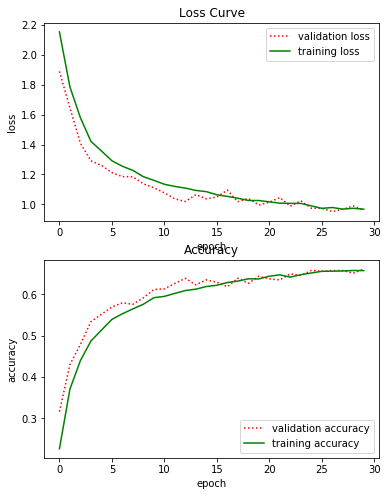

In [9]:
#################################################################################################################
eval_model1 = model_param_eval(model_name='model1.h5', net=net)
eval_model1.train_eval(INITIAL_LR=0.01, trainloader= trainloader1, valloader=valloader1,plot=True)

In [10]:
#3(c) batch normalization & larger learning rates
class BN_LeNet5(nn.Module):
    def __init__(self):
        super(BN_LeNet5, self).__init__()  
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0, bias=True)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 =nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 =  nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
                               
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.bn1(out)
        out = F.max_pool2d(out, kernel_size = 2, stride = 2)
        out = F.relu(self.conv2(out))
        out = self.bn2(out)
        out = F.max_pool2d(out, kernel_size = 2, stride = 2)
        out = out.view(out.size(0),-1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        return out
bnnet = BN_LeNet5()
bnnet = bnnet.to(device)

[Errno 2] No such file or directory: './saved_models/model3.h5'
Checkpoint not found.
Training from scratch ...
Starting from learning rate 0.100000:
2019-10-09 15:42:31.036716
Epoch 0:
352
Training loss: 1.7873, Training accuracy: 0.3575
2019-10-09 15:42:42.717826
Validation...
Validation loss: 1.5559, Validation accuracy: 0.4616
Saving ...
2019-10-09 15:42:43.827802
Epoch 1:
352
Training loss: 1.4464, Training accuracy: 0.4794
2019-10-09 15:42:55.421083
Validation...
Validation loss: 1.3508, Validation accuracy: 0.5190
Saving ...
2019-10-09 15:42:56.520076
Epoch 2:
352
Training loss: 1.3528, Training accuracy: 0.5218
2019-10-09 15:43:08.173964
Validation...
Validation loss: 1.2353, Validation accuracy: 0.5640
Current learning rate has decayed to 0.100000
Saving ...
2019-10-09 15:43:09.288252
Epoch 3:
352
Training loss: 1.2864, Training accuracy: 0.5474
2019-10-09 15:43:20.819764
Validation...
Validation loss: 1.2171, Validation accuracy: 0.5676
Saving ...
2019-10-09 15:43:21.960440
E

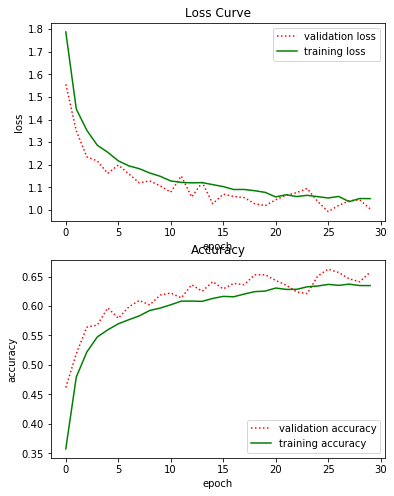

In [12]:
eval_model2 = model_param_eval(model_name='model3.h5', net=bnnet)
eval_model2.train_eval(INITIAL_LR=0.1, trainloader= trainloader1, valloader=valloader1,plot=True)

[Errno 2] No such file or directory: './saved_models/model32.h5'
Checkpoint not found.
Training from scratch ...
Starting from learning rate 0.100000:
2019-10-10 18:07:53.198117
Epoch 0:
352
Training loss: 2.0307, Training accuracy: 0.2547
2019-10-10 18:08:08.868948
Validation...
Validation loss: 1.8043, Validation accuracy: 0.3240
Saving ...
2019-10-10 18:08:10.200403
Epoch 1:
352
Training loss: 1.7912, Training accuracy: 0.3317
2019-10-10 18:08:23.324989
Validation...
Validation loss: 1.7963, Validation accuracy: 0.3386
Saving ...
2019-10-10 18:08:24.945708
Epoch 2:
352
Training loss: 1.7715, Training accuracy: 0.3432
2019-10-10 18:08:36.422495
Validation...
Validation loss: 1.7459, Validation accuracy: 0.3666
Current learning rate has decayed to 0.100000
Saving ...
2019-10-10 18:08:37.556976
Epoch 3:
352
Training loss: 1.7432, Training accuracy: 0.3573
2019-10-10 18:08:49.135514
Validation...
Validation loss: 1.6928, Validation accuracy: 0.3772
Saving ...
2019-10-10 18:08:50.267286


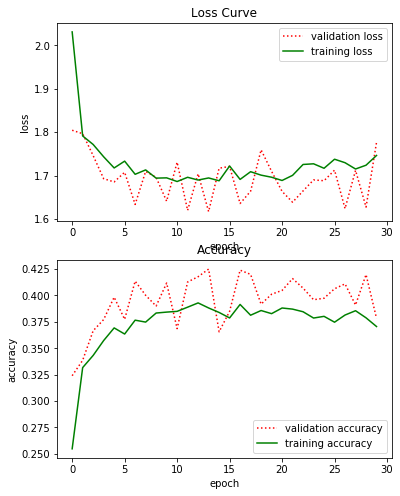

In [12]:
eval_model22 = model_param_eval(model_name='model32.h5', net=net)
eval_model22.train_eval(INITIAL_LR=0.1, trainloader= trainloader1, valloader=valloader1,plot=True)

[Errno 2] No such file or directory: './saved_models/model31.h5'
Checkpoint not found.
Training from scratch ...
Starting from learning rate 0.010000:
2019-10-10 05:03:28.060572
Epoch 0:
352
Training loss: 1.8263, Training accuracy: 0.3406
2019-10-10 05:03:43.972958
Validation...
Validation loss: 1.4376, Validation accuracy: 0.4754
Saving ...
2019-10-10 05:03:45.099188
Epoch 1:
352
Training loss: 1.4419, Training accuracy: 0.4769
2019-10-10 05:03:56.986424
Validation...
Validation loss: 1.3055, Validation accuracy: 0.5376
Saving ...
2019-10-10 05:03:58.372810
Epoch 2:
352
Training loss: 1.3445, Training accuracy: 0.5172
2019-10-10 05:04:09.644967
Validation...
Validation loss: 1.2173, Validation accuracy: 0.5620
Current learning rate has decayed to 0.010000
Saving ...
2019-10-10 05:04:10.745513
Epoch 3:
352
Training loss: 1.2657, Training accuracy: 0.5462
2019-10-10 05:04:22.233594
Validation...
Validation loss: 1.1767, Validation accuracy: 0.5858
Saving ...
2019-10-10 05:04:23.336142


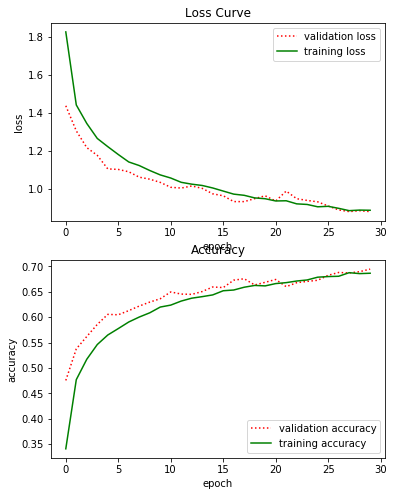

In [10]:
eval_model21 = model_param_eval(model_name='model31.h5', net=bnnet)
eval_model21.train_eval(INITIAL_LR=0.01, trainloader= trainloader1, valloader=valloader1,plot=True)

[Errno 2] No such file or directory: './saved_models/model4.h5'
Checkpoint not found.
Training from scratch ...
Starting from learning rate 0.010000:
2019-10-10 19:51:54.038987
Epoch 0:
352
Training loss: 1.8391, Training accuracy: 0.3393
2019-10-10 19:52:09.945294
Validation...
Validation loss: 1.4335, Validation accuracy: 0.4748
Saving ...
2019-10-10 19:52:11.085134
Epoch 1:
352
Training loss: 1.4372, Training accuracy: 0.4809
2019-10-10 19:52:22.368976
Validation...
Validation loss: 1.3071, Validation accuracy: 0.5314
Saving ...
2019-10-10 19:52:23.771232
Epoch 2:
352
Training loss: 1.3228, Training accuracy: 0.5303
2019-10-10 19:52:35.116981
Validation...
Validation loss: 1.2105, Validation accuracy: 0.5720
Current learning rate has decayed to 0.010000
Saving ...
2019-10-10 19:52:36.223864
Epoch 3:
352
Training loss: 1.2541, Training accuracy: 0.5537
2019-10-10 19:52:48.286446
Validation...
Validation loss: 1.2161, Validation accuracy: 0.5686
2019-10-10 19:52:49.339524
Epoch 4:
352

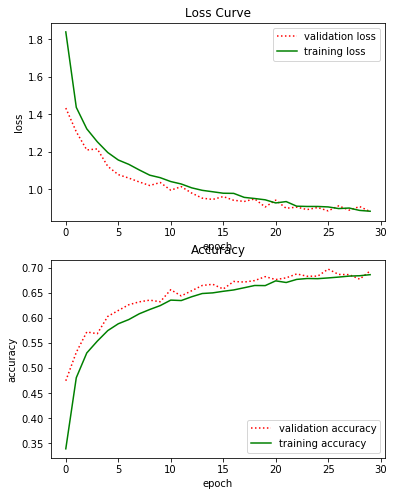

In [10]:
#4(a) hyperparameter tuning
eval_model3 = model_param_eval(model_name='model4.h5', net=bnnet, EPOCHS = 30)
eval_model3.train_eval(INITIAL_LR=0.01, REG=1e-4, trainloader= trainloader1, valloader=valloader1,plot=True)

[Errno 2] No such file or directory: './saved_models/model5.h5'
Checkpoint not found.
Training from scratch ...
Starting from learning rate 0.100000:
2019-10-10 20:03:55.162537
Epoch 0:
352
Training loss: 1.7036, Training accuracy: 0.3832
2019-10-10 20:04:11.297049
Validation...
Validation loss: 1.4573, Validation accuracy: 0.4722
Saving ...
2019-10-10 20:04:12.549059
Epoch 1:
352
Training loss: 1.4435, Training accuracy: 0.4782
2019-10-10 20:04:24.375845
Validation...
Validation loss: 1.2935, Validation accuracy: 0.5446
Saving ...
2019-10-10 20:04:25.833012
Epoch 2:
352
Training loss: 1.3667, Training accuracy: 0.5143
2019-10-10 20:04:37.879773
Validation...
Validation loss: 1.3106, Validation accuracy: 0.5392
Current learning rate has decayed to 0.100000
2019-10-10 20:04:38.980108
Epoch 3:
352
Training loss: 1.3149, Training accuracy: 0.5346
2019-10-10 20:04:50.799580
Validation...
Validation loss: 1.2356, Validation accuracy: 0.5816
Saving ...
2019-10-10 20:04:52.080834
Epoch 4:
352

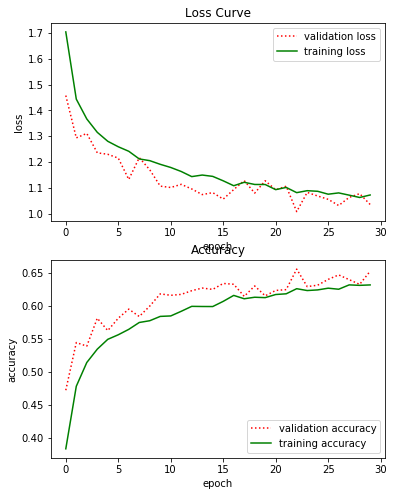

In [11]:
eval_model4 = model_param_eval(model_name='model5.h5', net=bnnet, EPOCHS=30)
eval_model4.train_eval(INITIAL_LR=0.1, REG=1e-4, trainloader= trainloader1, valloader=valloader1,plot=True)

[Errno 2] No such file or directory: './saved_models/model6.h5'
Checkpoint not found.
Training from scratch ...
Starting from learning rate 0.010000:
2019-10-10 20:13:58.877028
Epoch 0:
352
Training loss: 1.9796, Training accuracy: 0.2937
2019-10-10 20:14:14.532973
Validation...
Validation loss: 1.7323, Validation accuracy: 0.3720
Saving ...
2019-10-10 20:14:15.640656
Epoch 1:
352
Training loss: 1.5720, Training accuracy: 0.4204
2019-10-10 20:14:26.968967
Validation...
Validation loss: 1.3906, Validation accuracy: 0.4812
Saving ...
2019-10-10 20:14:28.338735
Epoch 2:
352
Training loss: 1.4329, Training accuracy: 0.4827
2019-10-10 20:14:39.726514
Validation...
Validation loss: 1.3516, Validation accuracy: 0.4996
Current learning rate has decayed to 0.010000
Saving ...
2019-10-10 20:14:40.956204
Epoch 3:
352
Training loss: 1.3626, Training accuracy: 0.5089
2019-10-10 20:14:52.317289
Validation...
Validation loss: 1.3159, Validation accuracy: 0.5170
Saving ...
2019-10-10 20:14:53.558051
E

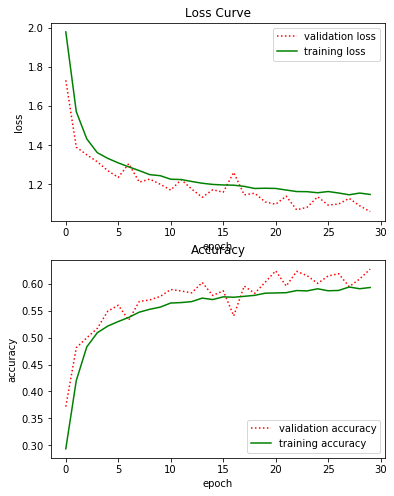

In [12]:
eval_model5 = model_param_eval(model_name='model6.h5', net=bnnet, EPOCHS=30)
eval_model5.train_eval(INITIAL_LR=0.01, REG=1e-2, trainloader= trainloader1, valloader=valloader1,plot=True)

[Errno 2] No such file or directory: './saved_models/model7.h5'
Checkpoint not found.
Training from scratch ...
Starting from learning rate 0.010000:
2019-10-10 20:34:57.624180
Epoch 0:
352
Training loss: 1.8921, Training accuracy: 0.3295
2019-10-10 20:35:14.559839
Validation...
Validation loss: 1.5854, Validation accuracy: 0.4464
Saving ...
2019-10-10 20:35:15.693985
Epoch 1:
352
Training loss: 1.6124, Training accuracy: 0.4286
2019-10-10 20:35:27.498532
Validation...
Validation loss: 1.5438, Validation accuracy: 0.4558
Saving ...
2019-10-10 20:35:28.882379
Epoch 2:
352
Training loss: 1.5603, Training accuracy: 0.4561
2019-10-10 20:35:41.180684
Validation...
Validation loss: 1.4557, Validation accuracy: 0.4950
Current learning rate has decayed to 0.010000
Saving ...
2019-10-10 20:35:42.298956
Epoch 3:
352
Training loss: 1.4049, Training accuracy: 0.4937
2019-10-10 20:35:54.025876
Validation...
Validation loss: 1.2965, Validation accuracy: 0.5324
Saving ...
2019-10-10 20:35:55.160869
E

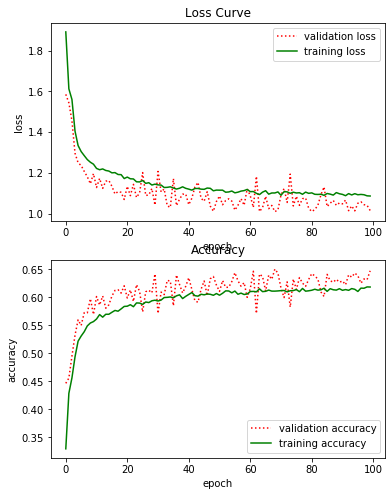

In [10]:
eval_model6 = model_param_eval(model_name='model7.h5', net=bnnet, EPOCHS=100)
eval_model6.train_eval(INITIAL_LR=0.01, REG=1e-2, trainloader= trainloader1, valloader=valloader1,plot=True)

[Errno 2] No such file or directory: './saved_models/model8.h5'
Checkpoint not found.
Training from scratch ...
Starting from learning rate 0.010000:
2019-10-10 21:07:12.519486
Epoch 0:
352
Training loss: 1.8407, Training accuracy: 0.3375
2019-10-10 21:07:28.519618
Validation...
Validation loss: 1.4434, Validation accuracy: 0.4666
Saving ...
2019-10-10 21:07:29.687111
Epoch 1:
352
Training loss: 1.4558, Training accuracy: 0.4720
2019-10-10 21:07:41.521336
Validation...
Validation loss: 1.3190, Validation accuracy: 0.5142
Saving ...
2019-10-10 21:07:42.957272
Epoch 2:
352
Training loss: 1.3359, Training accuracy: 0.5206
2019-10-10 21:07:54.661247
Validation...
Validation loss: 1.2370, Validation accuracy: 0.5584
Current learning rate has decayed to 0.010000
Saving ...
2019-10-10 21:07:55.780240
Epoch 3:
352
Training loss: 1.2620, Training accuracy: 0.5483
2019-10-10 21:08:07.368963
Validation...
Validation loss: 1.1926, Validation accuracy: 0.5776
Saving ...
2019-10-10 21:08:08.480205
E

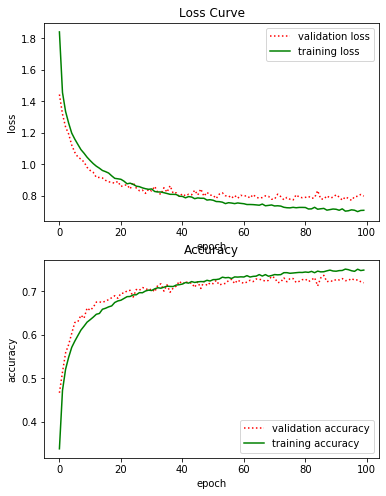

In [11]:
eval_model7 = model_param_eval(model_name='model8.h5', net=bnnet, EPOCHS=100)
eval_model7.train_eval(INITIAL_LR=0.01, REG=1e-4, trainloader= trainloader1, valloader=valloader1,plot=True)

[Errno 2] No such file or directory: './saved_models/model9.h5'
Checkpoint not found.
Training from scratch ...
Starting from learning rate 0.010000:
2019-10-10 21:33:58.761415
Epoch 0:
352
Training loss: 2.0458, Training accuracy: 0.3006
2019-10-10 21:34:15.519558
Validation...
Validation loss: 1.9183, Validation accuracy: 0.3482
Saving ...
2019-10-10 21:34:16.736211
Epoch 1:
352
Training loss: 1.8130, Training accuracy: 0.3806
2019-10-10 21:34:28.653226
Validation...
Validation loss: 1.7166, Validation accuracy: 0.4160
Saving ...
2019-10-10 21:34:30.217460
Epoch 2:
352
Training loss: 1.6752, Training accuracy: 0.4250
2019-10-10 21:34:42.038908
Validation...
Validation loss: 1.5586, Validation accuracy: 0.4592
Current learning rate has decayed to 0.010000
Saving ...
2019-10-10 21:34:43.141294
Epoch 3:
352
Training loss: 1.5773, Training accuracy: 0.4525
2019-10-10 21:34:55.130538
Validation...
Validation loss: 1.5629, Validation accuracy: 0.4632
Saving ...
2019-10-10 21:34:56.286245
E

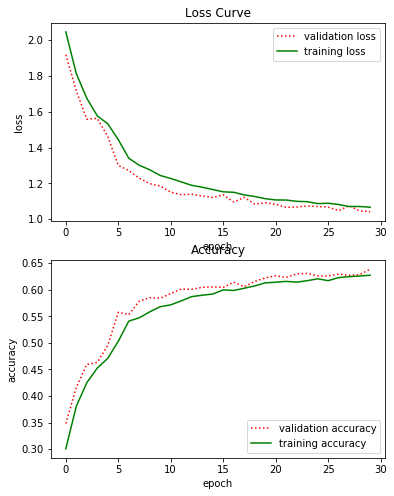

In [11]:
eval_model8 = model_param_eval(model_name='model9.h5', net=bnnet, EPOCHS=30)
eval_model8.train_eval(INITIAL_LR=0.01, REG=1e-3, trainloader= trainloader1, valloader=valloader1,plot=True)

[Errno 2] No such file or directory: './saved_models/model10.h5'
Checkpoint not found.
Training from scratch ...
Starting from learning rate 0.010000:
2019-10-10 18:40:05.456148
Epoch 0:
352
Training loss: 1.8941, Training accuracy: 0.3316
2019-10-10 18:40:22.098930
Validation...
Validation loss: 1.5803, Validation accuracy: 0.4538
Saving ...
2019-10-10 18:40:23.256255
Epoch 1:
352
Training loss: 1.5013, Training accuracy: 0.4749
2019-10-10 18:40:34.701692
Validation...
Validation loss: 1.3037, Validation accuracy: 0.5258
Saving ...
2019-10-10 18:40:36.122578
Epoch 2:
352
Training loss: 1.3288, Training accuracy: 0.5281
2019-10-10 18:40:47.732986
Validation...
Validation loss: 1.2120, Validation accuracy: 0.5734
Current learning rate has decayed to 0.010000
Saving ...
2019-10-10 18:40:48.850912
Epoch 3:
352
Training loss: 1.2368, Training accuracy: 0.5566
2019-10-10 18:41:00.568987
Validation...
Validation loss: 1.1476, Validation accuracy: 0.5834
Saving ...
2019-10-10 18:41:01.671699


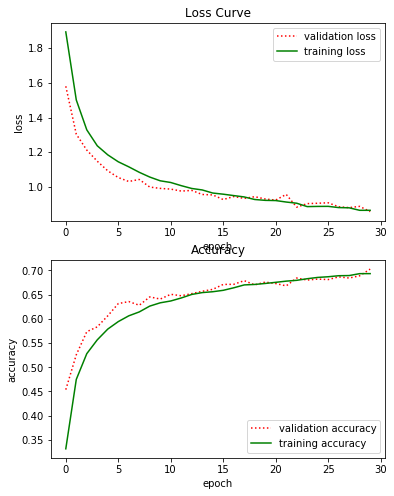

In [12]:
eval_model9 = model_param_eval(model_name='model10.h5', net=bnnet, EPOCHS=30)
eval_model9.train_eval(INITIAL_LR=0.01, REG=5e-5, trainloader= trainloader1, valloader=valloader1,plot=True)

[Errno 2] No such file or directory: './saved_models/model11.h5'
Checkpoint not found.
Training from scratch ...
Starting from learning rate 0.008000:
2019-10-10 19:09:45.121882
Epoch 0:
352
Training loss: 1.9068, Training accuracy: 0.3308
2019-10-10 19:10:01.465004
Validation...
Validation loss: 1.6070, Validation accuracy: 0.4464
Saving ...
2019-10-10 19:10:02.619853
Epoch 1:
352
Training loss: 1.4771, Training accuracy: 0.4684
2019-10-10 19:10:14.427428
Validation...
Validation loss: 1.2927, Validation accuracy: 0.5384
Saving ...
2019-10-10 19:10:15.870917
Epoch 2:
352
Training loss: 1.3371, Training accuracy: 0.5212
2019-10-10 19:10:27.632001
Validation...
Validation loss: 1.1925, Validation accuracy: 0.5750
Current learning rate has decayed to 0.008000
Saving ...
2019-10-10 19:10:28.766251
Epoch 3:
352
Training loss: 1.2557, Training accuracy: 0.5503
2019-10-10 19:10:40.472241
Validation...
Validation loss: 1.1120, Validation accuracy: 0.6050
Saving ...
2019-10-10 19:10:41.606030


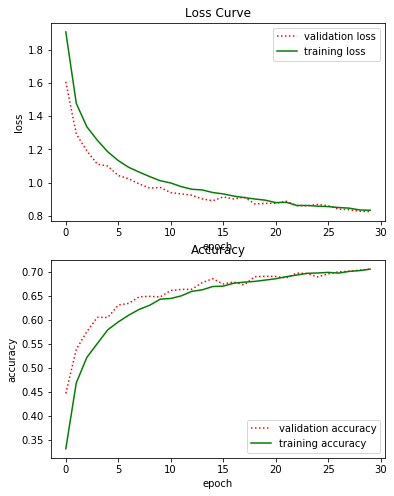

In [10]:
eval_model10 = model_param_eval(model_name='model11.h5', net=bnnet, EPOCHS=30)
eval_model10.train_eval(INITIAL_LR=0.008, REG=1e-4, trainloader= trainloader1, valloader=valloader1,plot=True)

[Errno 2] No such file or directory: './saved_models/model12.h5'
Checkpoint not found.
Training from scratch ...
Starting from learning rate 0.010000:
2019-10-10 19:20:19.858143
Epoch 0:
352
Training loss: 1.8036, Training accuracy: 0.3504
2019-10-10 19:20:35.896967
Validation...
Validation loss: 1.4932, Validation accuracy: 0.4512
Saving ...
2019-10-10 19:20:37.064809
Epoch 1:
352
Training loss: 1.4271, Training accuracy: 0.4817
2019-10-10 19:20:48.713710
Validation...
Validation loss: 1.3150, Validation accuracy: 0.5168
Saving ...
2019-10-10 19:20:50.153133
Epoch 2:
352
Training loss: 1.3103, Training accuracy: 0.5324
2019-10-10 19:21:01.806985
Validation...
Validation loss: 1.2056, Validation accuracy: 0.5714
Current learning rate has decayed to 0.010000
Saving ...
2019-10-10 19:21:02.938915
Epoch 3:
352
Training loss: 1.2410, Training accuracy: 0.5572
2019-10-10 19:21:14.606678
Validation...
Validation loss: 1.1438, Validation accuracy: 0.5858
Saving ...
2019-10-10 19:21:15.730608


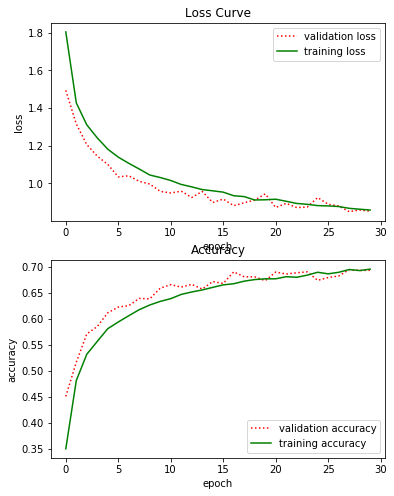

In [11]:
eval_model11 = model_param_eval(model_name='model12.h5', net=bnnet, EPOCHS=30)
eval_model11.train_eval(INITIAL_LR=0.01, REG=5e-4, trainloader= trainloader1, valloader=valloader1,plot=True)

[Errno 2] No such file or directory: './saved_models/model13.h5'
Checkpoint not found.
Training from scratch ...
Starting from learning rate 0.010000:
2019-10-10 19:28:31.661385
Epoch 0:
352
Training loss: 2.0239, Training accuracy: 0.2942
2019-10-10 19:28:47.175864
Validation...
Validation loss: 1.6411, Validation accuracy: 0.4226
Saving ...
2019-10-10 19:28:48.324523
Epoch 1:
352
Training loss: 1.6241, Training accuracy: 0.4276
2019-10-10 19:28:59.905241
Validation...
Validation loss: 1.4768, Validation accuracy: 0.4854
Saving ...
2019-10-10 19:29:01.336053
Epoch 2:
352
Training loss: 1.5189, Training accuracy: 0.4740
2019-10-10 19:29:13.292242
Validation...
Validation loss: 1.3898, Validation accuracy: 0.5206
Current learning rate has decayed to 0.010000
Saving ...
2019-10-10 19:29:14.412830
Epoch 3:
352
Training loss: 1.3487, Training accuracy: 0.5252
2019-10-10 19:29:26.175013
Validation...
Validation loss: 1.1694, Validation accuracy: 0.5842
Saving ...
2019-10-10 19:29:27.291105


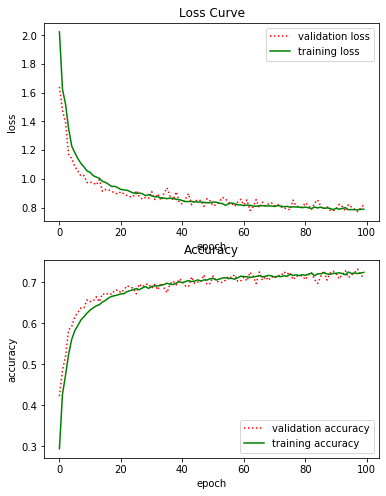

In [10]:
eval_model12 = model_param_eval(model_name='model13.h5', net=bnnet, EPOCHS=100)
eval_model12.train_eval(INITIAL_LR=0.01, REG=1e-3, trainloader= trainloader1, valloader=valloader1,plot=True)

In [11]:
class model_param_eval_decay():
    def __init__(self,model_name, net=net, EPOCHS = 30, DECAY = 1, DECAY_EPOCHS=2):
        self.model_name = model_name
        self.net = net
        self.EPOCHS = EPOCHS
        self.DECAY = DECAY
        self.DECAY_EPOCHS = DECAY_EPOCHS
    
    def train_eval(self, trainloader=trainloader, valloader=valloader, REG=REG, INITIAL_LR=INITIAL_LR, MOMENTUM=MOMENTUM, plot=False):
        TRAIN_FROM_SCRATCH = False
        # Code for loading checkpoint and recover epoch id.
        CKPT_PATH = "./saved_models/" + self.model_name
        def get_checkpoint(ckpt_path):
            try:
                ckpt = torch.load(ckpt_path)
            except Exception as e:
                print(e)
                return None
            return ckpt

        ckpt = get_checkpoint(CKPT_PATH)
        if ckpt is None or TRAIN_FROM_SCRATCH:
            if not TRAIN_FROM_SCRATCH:
                print("Checkpoint not found.")
            print("Training from scratch ...")
            start_epoch = 0
            current_learning_rate = INITIAL_LR
        else:
            print("Successfully loaded checkpoint: %s" %CKPT_PATH)
            self.net.load_state_dict(ckpt['net'])
            start_epoch = ckpt['epoch'] + 1
            current_learning_rate = ckpt['lr']
            print("Starting from epoch %d " %start_epoch)

        print("Starting from learning rate %f:" %current_learning_rate)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)

        global_step = 0
        best_val_acc = 0
        
        trainloss_list = list()
        valloss_list = list()
        trainacc_list = list()
        valacc_list = list()
        
        for i in range(start_epoch, self.EPOCHS):
            print(datetime.datetime.now())
            self.net.train()
            print("Epoch %d:" %i)

            total_examples = 0
            correct_examples = 0

            train_loss = 0
            train_acc = 0
            print(len(trainloader))
            for batch_idx, (inputs, targets) in enumerate(trainloader):
                inputs = inputs.to(device)
                targets = targets.to(device)
                optimizer.zero_grad()
                outputs = self.net(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs.data, 1)
                total_examples += targets.size(0)
                correct_examples += torch.sum(predicted == targets.data).float()

                train_loss += loss

                global_step += 1
                if global_step % 100 == 0:
                    avg_loss = train_loss / (batch_idx + 1)
                pass
            avg_acc = correct_examples / total_examples
            print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
            print(datetime.datetime.now())
            trainacc_list.append(avg_acc)
            trainloss_list.append(avg_loss)
        
            # Validate on the validation dataset
            print("Validation...")
            total_examples = 0
            correct_examples = 0

            self.net.eval()

            val_loss = 0
            val_acc = 0
            # Disable gradient during validation
            with torch.no_grad():
                for batch_idx, (inputs, targets) in enumerate(valloader):
                    # Copy inputs to device
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    # Zero the gradient
                    optimizer.zero_grad()
                    # Generate output from the DNN.
                    outputs = self.net(inputs)
                    loss = criterion(outputs, targets)
                    # Calculate predicted labels
                    _, predicted = outputs.max(1)
                    # Calculate accuracy
                    total_examples += targets.size(0)
                    correct_examples += torch.sum(predicted == targets.data).float()
                    val_loss += loss

            avg_loss = val_loss / len(valloader)
            avg_acc = correct_examples / total_examples
            print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

            valacc_list.append(avg_acc)
            valloss_list.append(avg_loss)

            current_learning_rate = INITIAL_LR

            DECAY_EPOCHS = self.DECAY_EPOCHS
            DECAY = self.DECAY
            if i % DECAY_EPOCHS == 0 and i != 0:
                current_learning_rate = current_learning_rate*DECAY
                for param_group in optimizer.param_groups:
                    # Assign the learning rate parameter
                    param_group['lr'] = current_learning_rate

                print("Current learning rate has decayed to %f" %current_learning_rate)

            # Save for checkpoint
            if avg_acc > best_val_acc:
                best_val_acc = avg_acc
                if not os.path.exists(CHECKPOINT_PATH):
                    os.makedirs(CHECKPOINT_PATH)
                print("Saving ...")
                state = {'net': self.net.state_dict(),
                         'epoch': i,
                         'lr': current_learning_rate}
                torch.save(state, os.path.join(CHECKPOINT_PATH, self.model_name))
        print("Optimization finished.")
        
        if plot == True:
            plt.figure(figsize=(6,8))
            plt.subplot(211)
            plt.title('Loss Curve')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.plot(valloss_list, label='validation loss', color='red', linestyle = ':')
            plt.plot(trainloss_list, label='training loss', color='green', linestyle='-')
            plt.legend()

            plt.subplot(212)
            plt.title('Accuracy')
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            plt.plot(valacc_list, label='validation accuracy', color='red', linestyle=':')
            plt.plot(trainacc_list, label='training accuracy', color='green', linestyle='-')
            plt.legend()
            plt.show()
    

[Errno 2] No such file or directory: './saved_models/model14.h5'
Checkpoint not found.
Training from scratch ...
Starting from learning rate 0.010000:
2019-10-10 18:14:19.999867
Epoch 0:
352
Training loss: 1.9275, Training accuracy: 0.3255
2019-10-10 18:14:31.640957
Validation...
Validation loss: 1.5716, Validation accuracy: 0.4218
Saving ...
2019-10-10 18:14:32.962212
Epoch 1:
352
Training loss: 1.4588, Training accuracy: 0.4672
2019-10-10 18:14:44.325319
Validation...
Validation loss: 1.3346, Validation accuracy: 0.5236
Saving ...
2019-10-10 18:14:45.535628
Epoch 2:
352
Training loss: 1.3368, Training accuracy: 0.5211
2019-10-10 18:14:56.934154
Validation...
Validation loss: 1.2505, Validation accuracy: 0.5560
Saving ...
2019-10-10 18:14:58.122821
Epoch 3:
352
Training loss: 1.2665, Training accuracy: 0.5426
2019-10-10 18:15:09.614671
Validation...
Validation loss: 1.1729, Validation accuracy: 0.5836
Saving ...
2019-10-10 18:15:10.940431
Epoch 4:
352
Training loss: 1.2117, Training a

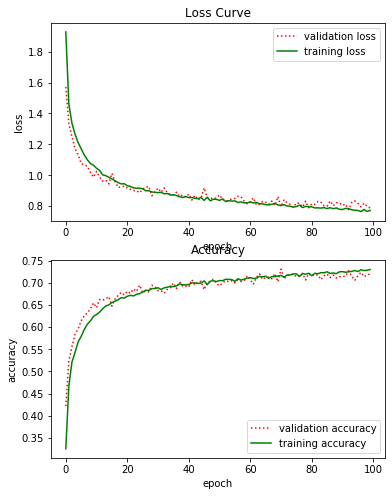

In [14]:
#4(b)
eval_model13 = model_param_eval_decay(model_name='model14.h5', net=bnnet, EPOCHS=100, DECAY = 3, DECAY_EPOCHS=0.98)
eval_model13.train_eval(INITIAL_LR=0.01, REG=1e-3, trainloader= trainloader1, valloader=valloader1,plot=True)

[Errno 2] No such file or directory: './saved_models/model15.h5'
Checkpoint not found.
Training from scratch ...
Starting from learning rate 0.010000:
2019-10-10 17:34:33.880561
Epoch 0:
352
Training loss: 1.9649, Training accuracy: 0.3076
2019-10-10 17:34:50.725639
Validation...
Validation loss: 1.6716, Validation accuracy: 0.4288
Saving ...
2019-10-10 17:34:51.993760
Epoch 1:
352
Training loss: 1.6662, Training accuracy: 0.4243
2019-10-10 17:35:03.901683
Validation...
Validation loss: 1.5329, Validation accuracy: 0.4750
Saving ...
2019-10-10 17:35:05.316345
Epoch 2:
352
Training loss: 1.5290, Training accuracy: 0.4730
2019-10-10 17:35:17.217742
Validation...
Validation loss: 1.4433, Validation accuracy: 0.5016
Saving ...
2019-10-10 17:35:18.386009
Epoch 3:
352
Training loss: 1.4198, Training accuracy: 0.5081
2019-10-10 17:35:30.142453
Validation...
Validation loss: 1.3292, Validation accuracy: 0.5404
Saving ...
2019-10-10 17:35:31.293533
Epoch 4:
352
Training loss: 1.3746, Training a

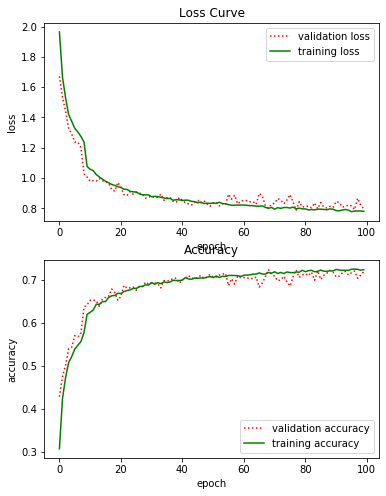

In [15]:
eval_model14 = model_param_eval_decay(model_name='model15.h5', net=bnnet, EPOCHS=100, DECAY = 10, DECAY_EPOCHS=0.7)
eval_model14.train_eval(INITIAL_LR=0.01, REG=1e-3, trainloader= trainloader1, valloader=valloader1,plot=True)